In [3]:
import numpy as np 
import pandas as pd
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

In [4]:
conv_base = VGG16(weights = "imagenet",
                  include_top = False,
                  input_shape = (256,256,3)
                  )

In [5]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in conv_base.layers:
    print(layer.name, layer.trainable)
    

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [7]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation= 'sigmoid'))

In [9]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'boss_train',
    labels = 'inferred',
    label_mode = 'int',
    # color_mode = 'grayscale',
    batch_size = 32,
    image_size = (256,256)
)

Found 1000 files belonging to 2 classes.


In [10]:
validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'boos_test',
    labels = 'inferred',
    label_mode = 'int',
    # color_mode = 'grayscale',
    batch_size = 32,
    image_size = (256,256)
)

Found 200 files belonging to 2 classes.


In [20]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
import tensorflow as tf
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [22]:
#

In [23]:
def process(image, label):
  image = tensorflow.cast(image/255. , tensorflow.float32)
  return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [24]:
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5),
    loss = 'binary_crossentropy',
    metrics=METRICS
    )

In [25]:
history = model.fit(train_ds, epochs = 10, validation_data= validation_ds)

Epoch 1/10
32/32 [==============================] - 463s 14s/step - loss: 0.7074 - accuracy: 0.5020 - precision: 0.5019 - recall: 0.5220 - auc: 0.4859 - f1_score: 0.3527 - val_loss: 0.6969 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1_score: 0.6783
Epoch 2/10
32/32 [==============================] - 392s 12s/step - loss: 0.6985 - accuracy: 0.5080 - precision: 0.5069 - recall: 0.5840 - auc: 0.5145 - f1_score: 0.3757 - val_loss: 0.7100 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 399s 12s/step - loss: 0.7039 - accuracy: 0.4900 - precision: 0.4861 - recall: 0.3500 - auc: 0.4587 - f1_score: 0.2466 - val_loss: 0.7103 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1_score: 0.6846
Epoch 4/10
32/32 [==============================] - 397s 12s/step - loss: 0.6986 - accuracy: 0

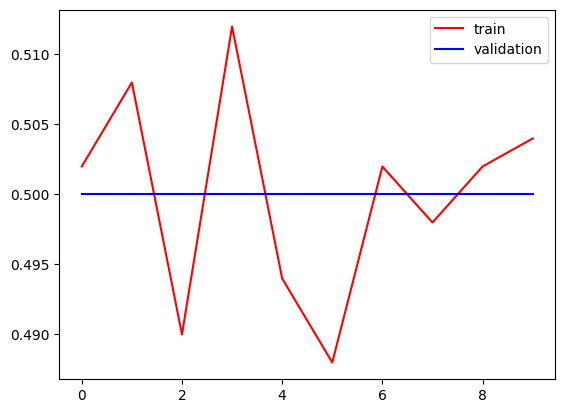

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

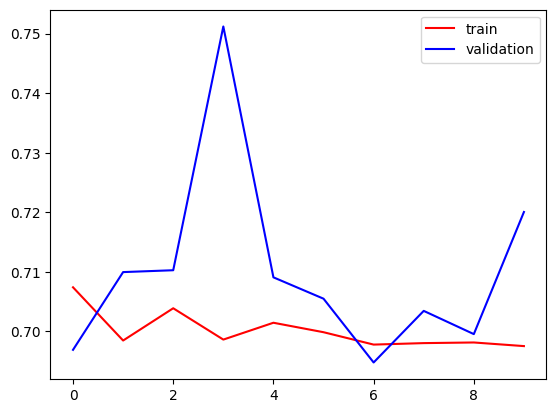

In [28]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

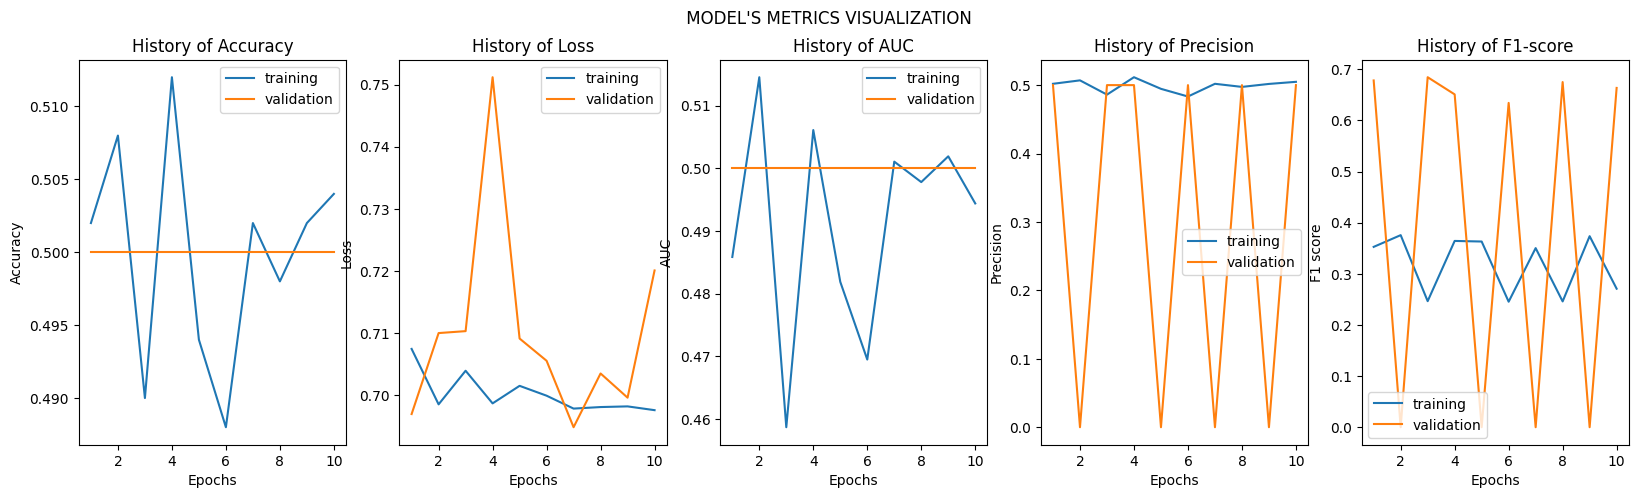

In [29]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
score = model.evaluate(test_dataset, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

In [30]:
predictions = model.predict(validation_ds,verbose=1)
import numpy as np
class_index = 2
pred = predictions.argmax(axis=1)
print(pred)

7/7 [==============================] - 75s 10s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [31]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

print(accuracy_score(class_index,pred))

cm = confusion_matrix(class_index,pred)
print(cm)

InvalidParameterError: The 'y_true' parameter of accuracy_score must be an array-like or a sparse matrix. Got 2 instead.

In [32]:
model.save('model.h5')

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tf.keras.models.load